# 因子回测

## 导入模块

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker
from scipy import stats
import feather
import os
import statsmodels.api as sm
import sunlandsdatasdk as sd
%load_ext line_profiler

## 读入日线数据

### 读入日线数据

In [2]:
price_1d = feather.read_dataframe('../data/StockPriceK1d_20240630.feather')

### 计算调仓日

In [3]:
trade_date = price_1d['date'].sort_values().unique()
mes = pd.date_range(start='2019-08-01', end=trade_date[-1]+pd.DateOffset(months=1), freq='1ME')
adj_date = np.array([], dtype=np.datetime64)
for me in mes:
    trade_date_before = trade_date[trade_date <= me]
    ad = trade_date_before[-1]
    adj_date = np.append(adj_date, ad)
map_mon_adj = {ad.year * 100 + ad.month: ad for ad in adj_date}

### 计算每两个调仓日之间的收益

In [4]:
price_1d['year_mon'] = price_1d['date'].dt.year * 100 + price_1d['date'].dt.month

def ret_acc_temp(ret):
    return (1 + ret).prod() - 1

def ret_acc(price_1d):
    preclose = price_1d.iloc[0]['preclose']
    close = price_1d.iloc[-1]['close']
    return (close - preclose) / preclose

price_adj = (
    price_1d[(price_1d['date'] >= '2019-08-01') & (price_1d['date'] <= '2024-12-31')]
        .groupby(['issue', 'year_mon'])[['preclose', 'close']]
        .apply(ret_acc)
        .reset_index()
)
price_adj = price_adj.rename(columns={0: 'ret'})
price_adj['date'] = price_adj['year_mon'].apply(map_mon_adj.get)
price_adj['ret_next'] = price_adj.groupby('issue')['ret'].shift(-1)
price_adj = price_adj[['issue', 'date', 'ret', 'ret_next']]
price_adj = price_adj.dropna(subset='ret_next')

### 剔除股票

In [5]:
def newly_listed(date, timedelta='180D'):
    start_date = date.min()
    newly = (date <= start_date + pd.Timedelta(timedelta))
    return newly

price_1d['newly_listed'] = (
    price_1d
        .groupby('issue')['date']
        .transform(newly_listed)
)

price_adj = pd.merge(
    price_adj,
    price_1d[['issue', 'date', 'newly_listed', 'is_limit_sell', 'is_limit_buy']],
    on=['issue', 'date'],
    how='left'
)

price_adj = price_adj[
    (~price_adj['newly_listed']) &
    (~price_adj['is_limit_buy'].astype(bool)) &
    (~price_adj['is_limit_sell'].astype(bool))
]
price_adj = price_adj[['issue', 'date', 'ret', 'ret_next']]

## 市值行业中性化

### 读入申万行业和市值

In [6]:
# sd.auth('*', '*')
# issues = price_1d['issue'].sort_values().unique()
# market_cap = sd.get_ricequant_factor(
#     issues,
#     start_date='2019-08-01',
#     end_date='2024-12-31',
#     fields=['market_cap_3']
# )
# market_cap = market_cap.reset_index()
# market_cap = market_cap.rename(columns={'market_cap_3': 'market_cap'})
# market_cap['date'] = pd.to_datetime(market_cap['date'])
# feather.write_dataframe(market_cap, '../data/market_cap.feather')

In [7]:
industry = feather.read_dataframe('../data/industry_classes.feather')
industry = industry.sort_values('date').set_index('date')
market_cap = feather.read_dataframe('../data/market_cap.feather')
market_cap['log_market_cap'] = market_cap['market_cap'].apply(np.log)
market_cap = market_cap.sort_values('date').set_index('date')
prc = price_1d.sort_values('date').set_index('date')

### 市值行业中性化

In [8]:
def neutral_calc(factor, factor_col):
    date = factor.name
    try:
        price_keys = prc.loc[date, 'issue']
        indus_keys = industry.loc[date, ['issue', 'L1']]
        cap_keys = market_cap.loc[date, ['issue', 'log_market_cap']]
    except KeyError:
        f = pd.DataFrame(columns=['issue', factor_col, 'indus_factor', 'neutral_factor'])
        return None

    f = factor.copy()
    f = f.merge(
        price_keys,
        on='issue',
        how='inner'
    )
    f = f.merge(
        indus_keys,
        on='issue',
        how='inner'
    )
    f['indus_mean'] = f.groupby('L1')[factor_col].transform('mean')
    f['indus_factor'] = f[factor_col] - f['indus_mean']
    
    f = f.merge(
        cap_keys,
        on='issue',
        how='left'
    )
    x = f['log_market_cap']
    x = sm.add_constant(x)
    y = f['indus_factor']
    result = sm.OLS(y, x).fit()
    f['neutral_factor'] = result.resid

    return f[['issue', factor_col, 'indus_factor', 'neutral_factor']]

## IC 测试

In [9]:
def IC_calc_once(factor, factor_col, ret_col):
    IC, p = stats.spearmanr(factor[factor_col], factor[ret_col])
    return IC

def IC_calc(factor, factor_col):
    f = factor.copy()
    f = pd.merge(
        f,
        price_adj,
        on=['issue', 'date'],
        how='inner'
    )  
    IC = (
        f
            .groupby('date')[[factor_col, 'ret_next']]
            .apply(IC_calc_once, factor_col=factor_col, ret_col='ret_next')
    )
    return IC

## 分组测试

In [10]:
def grouped_ret(f, factor_col):
    f_date = f.copy()
    q = f_date[factor_col].quantile(np.arange(0, 1.1, 0.1))
    qcut = pd.cut(
        f_date[factor_col],
        q,
        right=True,
        labels=np.arange(1, 11)
    )
    f_date['group'] = qcut
    ret = f_date.groupby('group', observed=False)['ret_next'].mean()
    return ret

def grouped_calc(factor, factor_col):
    f = pd.merge(
        factor,
        price_adj,
        on=['issue', 'date'],
        how='inner'
    )
    ret = (
        f
            .groupby('date')[[factor_col, 'ret', 'ret_next']]
            .apply(grouped_ret, factor_col=factor_col)
    )
    
    ret_annual = (1 + ret.mean()) ** 12 - 1
    plt.bar(ret_annual.index, ret_annual, color='#a60021')
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
    plt.show()
    
    long = (1 + ret[10]).cumprod()
    long_short = (1 + ret[10] - ret[1]).cumprod()
    plt.plot(long, linewidth=3, color='#a60021', label='long')
    plt.plot(long_short, linewidth=3, color='#ffc000', label='long-short')
    plt.legend()
    plt.grid()
    plt.show()

    return ret

## 点度中心性回测

### 读入数据

In [11]:
N_connect_num = feather.read_dataframe('../data/N_connect/N_connect_num.feather')
N_connect_size = feather.read_dataframe('../data/N_connect/N_connect_size.feather')

### 市值行业中性化

In [12]:
%%time
neutral_num = (
    N_connect_num
        .groupby('date')[['issue', 'N_connect']]
        .apply(neutral_calc, factor_col='N_connect')
        .reset_index()
)
neutral_size = (
    N_connect_size
        .groupby('date')[['issue', 'N_connect']]
        .apply(neutral_calc, factor_col='N_connect')
        .reset_index()
)

CPU times: total: 1.97 s
Wall time: 2.02 s


### IC 测试

In [13]:
df_IC = pd.DataFrame(columns=['factor', 'IC_mean', 'IC_IR', 't', "max", 'min'])
IC_num = IC_calc(neutral_num, factor_col='neutral_factor')
df_IC.loc[0]=[
        'N_connect_num',
        IC_num.mean(),
        IC_num.mean() / IC_num.std(),
        np.sqrt(len(IC_num)) * IC_num.mean() / IC_num.std(),
        IC_num.max(),
        IC_num.min()
    ]
IC_size = IC_calc(neutral_size, factor_col='neutral_factor')
df_IC.loc[1]=[
        'N_connect_size',
        IC_size.mean(),
        IC_size.mean() / IC_size.std(),
        np.sqrt(len(IC_size)) * IC_size.mean() / IC_size.std(),
        IC_size.max(),
        IC_size.min()
    ]
df_IC

,factor,IC_mean,IC_IR,t,max,min
0,N_connect_num,0.015018,0.327783,2.496320,0.114139,-0.101987
1,N_connect_size,0.014849,0.289587,2.205426,0.135635,-0.120130


### 分组测试

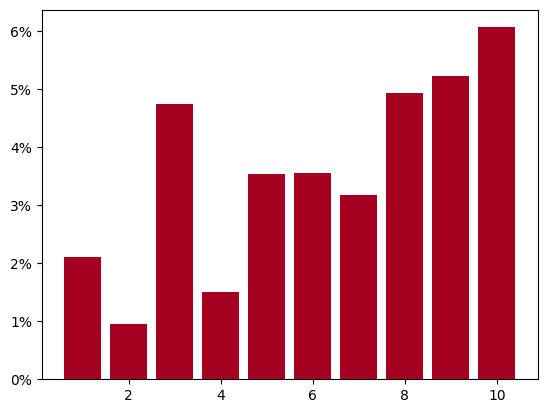

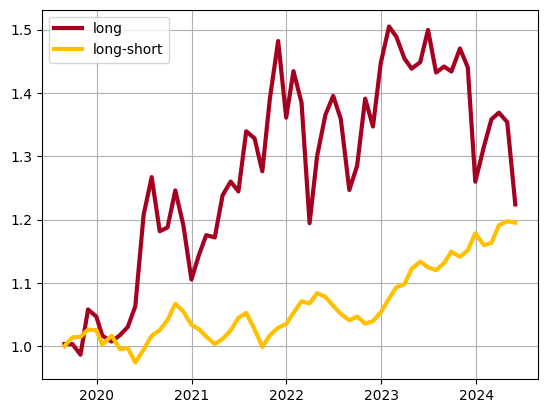

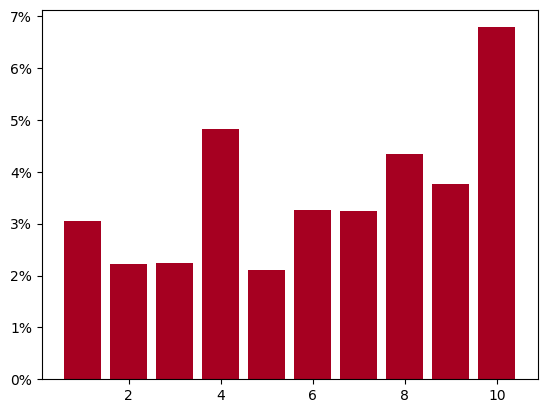

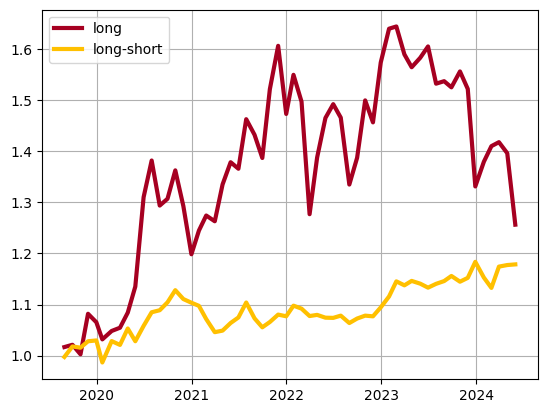

,factor,long_annual,long_sharpe,long_short_annual
0,N_connect_num,0.060690,0.326617,0.038810
1,N_connect_size,0.067855,0.351162,0.036383


In [14]:
df_grouped = pd.DataFrame(columns=['factor', 'long_annual', 'long_sharpe', 'long_short_annual'])
grouped_num = grouped_calc(neutral_num, factor_col='neutral_factor')
mean_annual_num = (1 + grouped_num[10].mean()) ** 12 - 1
std_annual_num = np.sqrt(12) * grouped_num[10].std()
long_short_num = (1 + (grouped_num[10] - grouped_num[1]).mean()) ** 12 - 1
df_grouped.loc[0]=[
    'N_connect_num',
    mean_annual_num,
    mean_annual_num / std_annual_num,
    long_short_num
]
grouped_size = grouped_calc(neutral_size, factor_col='neutral_factor')
mean_annual_size = (1 + grouped_size[10].mean()) ** 12 - 1
std_annual_size = np.sqrt(12) * grouped_size[10].std()
long_short_size = (1 + (grouped_size[10] - grouped_size[1]).mean()) ** 12 - 1
df_grouped.loc[1]=[
    'N_connect_size',
    mean_annual_size,
    mean_annual_size / std_annual_size,
    long_short_size
]
df_grouped